In [1]:
import pathlib
import time

import pandas as pd
import census
import us

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'svg'

from tqdm.auto import tqdm

api_key = pathlib.Path('api_key_secret.txt').read_text()

c = census.Census(api_key)

In [2]:
# https://data.census.gov/cedsci/table?q=gross%20rent%20san%20francisco&g=0100000US&tid=ACSDP1Y2021.DP04

search_state = us.states.CA.fips
start_year = 2010
end_year = 2021
stats_of_interest = {
    'B25064_001E': 'Median Rent',
    'B25077_001E': 'Median Value',
}

In [3]:
search_years = list(range(start_year, end_year+1))
census_data = []
reporter = tqdm(total=len(stats_of_interest)*len(search_years))
for stat_id, stat_name in stats_of_interest.items():
    for year in search_years:
        try:
            df = pd.DataFrame.from_records(c.acs1.get(('NAME', stat_id), {'for': 'county:*', 'in': 'state:{}'.format(search_state)}, year=year))
        except Exception:
            time.sleep(0.1)
            reporter.update()
            continue
        df = df.rename(columns={stat_id: 'Value', 'NAME': 'Name', 'state': 'State', 'county': 'County'})
        df['Statistic'] = stat_name
        df['Stat ID'] = stat_id
        df['Year'] = year
        census_data.append(df)
        time.sleep(0.1)
        reporter.update()
reporter.close()
census_data = pd.concat(census_data, ignore_index=True)
print(len(census_data))
census_data.head()

  0%|          | 0/24 [00:00<?, ?it/s]

886


,Name,Value,State,County,Statistic,Stat ID,Year
0,"Alameda County, California",1198.0,06,001,Median Rent,B25064_001E,2010
1,"Butte County, California",862.0,06,007,Median Rent,B25064_001E,2010
2,"Contra Costa County, California",1283.0,06,013,Median Rent,B25064_001E,2010
3,"El Dorado County, California",1098.0,06,017,Median Rent,B25064_001E,2010
4,"Fresno County, California",825.0,06,019,Median Rent,B25064_001E,2010


In [4]:
census_data.loc[census_data['Name'] == 'San Francisco County, California']

,Name,Value,State,County,Statistic,Stat ID,Year
24,"San Francisco County, California",1385.0,06,075,Median Rent,B25064_001E,2010
64,"San Francisco County, California",1407.0,06,075,Median Rent,B25064_001E,2011
117,"San Francisco County, California",1512.0,06,075,Median Rent,B25064_001E,2012
153,"San Francisco County, California",1491.0,06,075,Median Rent,B25064_001E,2013
165,"San Francisco County, California",1587.0,06,075,Median Rent,B25064_001E,2014
234,"San Francisco County, California",1659.0,06,075,Median Rent,B25064_001E,2015
266,"San Francisco County, California",1784.0,06,075,Median Rent,B25064_001E,2016
293,"San Francisco County, California",1836.0,06,075,Median Rent,B25064_001E,2017
328,"San Francisco County, California",1880.0,06,075,Median Rent,B25064_001E,2018
379,"San Francisco County, California",1959.0,06,075,Median Rent,B25064_001E,2019


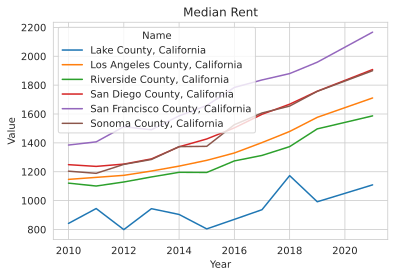

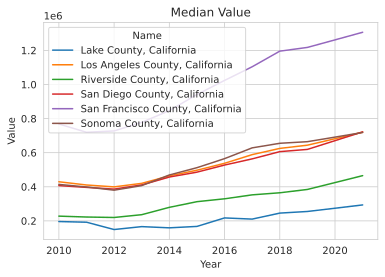

In [5]:
plot_counties = [
    'San Francisco County, California',
    # 'Alameda County, California', 'Santa Clara County, California',
    'San Diego County, California', 'Los Angeles County, California',
    'Riverside County, California',
    'Lake County, California', 'Sonoma County, California',
]
for stat_name in census_data['Statistic'].drop_duplicates():
    fig, ax = plt.subplots()
    sns.lineplot(data=census_data.loc[
        census_data['Name'].isin(plot_counties) &
        (census_data['Statistic'] == stat_name)
    ], x='Year', y='Value', hue='Name')
    ax.set_title(stat_name)

In [6]:
import cpi
cpi.update()

In [7]:
census_wide = census_data[['Name', 'State', 'County', 'Year']].drop_duplicates()
for stat_name in census_data['Statistic'].drop_duplicates():
    census_wide = census_wide.merge(census_data.loc[census_data['Statistic'] == stat_name].drop(columns=['Statistic', 'Stat ID']).rename(columns={'Value': stat_name}), on=['Name', 'State', 'County', 'Year'], how='left')
for stat_name in census_data['Statistic'].drop_duplicates():
    census_wide[stat_name+' ({} dollars)'.format(cpi.LATEST_YEAR)] = census_wide.apply(lambda x: cpi.inflate(x[stat_name], x['Year'], to=cpi.LATEST_YEAR), axis=1)
census_wide['Price-to-Rent Ratio ({} dollars)'.format(cpi.LATEST_YEAR)] = census_wide['Median Value ({} dollars)'.format(cpi.LATEST_YEAR)] / (census_wide['Median Rent ({} dollars)'.format(cpi.LATEST_YEAR)] * 12.0)
print(len(census_wide))
census_wide.loc[census_wide['Name'] == 'San Francisco County, California'].sort_values('Year')

443


,Name,State,County,Year,Median Rent,Median Value,Median Rent (2021 dollars),Median Value (2021 dollars),Price-to-Rent Ratio (2021 dollars)
24,"San Francisco County, California",06,075,2010,1385.0,768000.0,1721.087473,9.543648e+05,46.209386
64,"San Francisco County, California",06,075,2011,1407.0,719800.0,1694.925246,8.670982e+05,42.632078
117,"San Francisco County, California",06,075,2012,1512.0,727600.0,1784.483218,8.587235e+05,40.101411
153,"San Francisco County, California",06,075,2013,1491.0,778000.0,1734.295471,9.049510e+05,43.483121
165,"San Francisco County, California",06,075,2014,1587.0,846800.0,1816.493436,9.692543e+05,44.465448
234,"San Francisco County, California",06,075,2015,1659.0,941400.0,1896.653953,1.076257e+06,47.287523
266,"San Francisco County, California",06,075,2016,1784.0,1024000.0,2014.151587,1.156105e+06,47.832586
293,"San Francisco County, California",06,075,2017,1836.0,1104100.0,2029.621899,1.220537e+06,50.113471
328,"San Francisco County, California",06,075,2018,1880.0,1195700.0,2028.711267,1.290282e+06,53.000887
379,"San Francisco County, California",06,075,2019,1959.0,1217500.0,2076.337554,1.290424e+06,51.790880


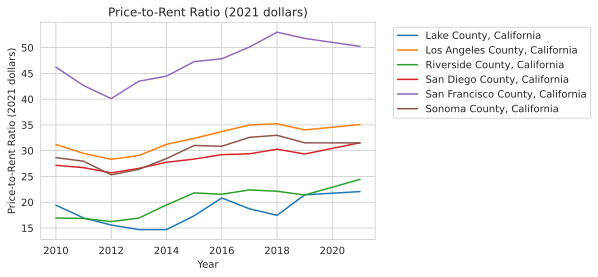

In [8]:
fig, ax = plt.subplots()
sns.lineplot(data=census_wide.loc[census_wide['Name'].isin(plot_counties)], x='Year', y='Price-to-Rent Ratio ({} dollars)'.format(cpi.LATEST_YEAR), hue='Name')
ax.set_title('Price-to-Rent Ratio ({} dollars)'.format(cpi.LATEST_YEAR))
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

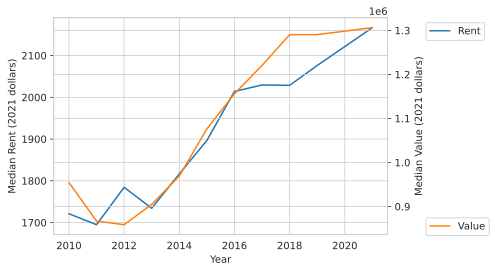

In [9]:
plot_county = 'San Francisco County, California'
df = census_wide.loc[census_wide['Name'] == plot_county]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.lineplot(data=df, x='Year', y='Median Rent ({} dollars)'.format(cpi.LATEST_YEAR), ax=ax1, color=sns.color_palette()[0], label='Rent')
sns.lineplot(data=df, x='Year', y='Median Value ({} dollars)'.format(cpi.LATEST_YEAR), ax=ax2, color=sns.color_palette()[1], label='Value')
df.head()
ax1.legend(bbox_to_anchor=(1.1, 1), loc="upper left")
ax2.legend(bbox_to_anchor=(1.1, 0.1), loc="upper left")